# Growth in Notebooks on Github 
How has the popularity of notebooks increased over the years? 

The growth in the number of Jupyter notebooks on github was slow at first but has increased significantly since the start of 2018. The 'dates' we have for these notebooks are the date on which the repository was most recently updated. However, the same pattern is seen when we look at the date on which the repository was created, so this pattern is due to an increase of use, not just that people are updating old notebooks (which would move up their date).

--------

### Which date to choose?
For each notebook, we have access to the following dates: 'created at', 'pushed at', and 'updated at'.
- *Created At*: Reflects wen the repository was created. May be older dates than the notebooks themselves. Could tell us that the framework actually added to a notebook in 2014 (pushed date) was used in 2012 (created date), leading to inconsistencies.
- *Pushed At*: The best indicator of the last true update. However, when looking at popularity, it would count updated notebooks incorrectly as 'new' notebooks.
- *Updated At*: This is when the github repository was last updated. An 'update' can include more than new code -- also looks at if language has changed, if there's a new stargazer, or if a contributor has been added. This isn't always related to file updates, so isn't very useful.
- **For analysis on notebook popularity, 'Created At' makes the most sense (when notebooks were actually added to GitHub).**
- **All future analysis (looking at package use, language version, etc. over time) will use 'Pushed At' as its date metric (package use, language version, etc. could have changed on 'Pushed At' date).**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import calendar

In [2]:
import load_data
notebooks, cells, owners, readmes, repos = load_data.load()

DATE_CHOICE = 'created_at'

Adding a truncated 'version' field to the notebooks dataframe. (Python 3.3.2 is truncated to 3.3).

In [3]:
python_versions_strings = notebooks[notebooks.lang_name == 'python'].lang_version
str_to_version = {}
for p in python_versions_strings.unique():
    if p == 'nan':
        str_to_version[p] = ''
    else:
        str_to_version[p] = float('.'.join(str(p).split('.')[0:2]))

Adding month and date created to notebooks dataframe.

In [4]:
notebooks['python_version'] = [
    '' if p.lang_name != 'python' 
    else str_to_version[p.lang_version] 
    for i, p in notebooks.iterrows()
]

over_time = notebooks.merge(repos, on = 'repo_id').copy()[['file','lang_name','python_version',DATE_CHOICE]]
over_time[DATE_CHOICE] = pd.to_datetime(over_time[DATE_CHOICE])
over_time['month'] = [c.month for c in over_time[DATE_CHOICE]]
over_time['year'] = [c.year for c in over_time[DATE_CHOICE]]
over_time.head()

,file,lang_name,python_version,created_at,month,year
0,danielcorbett..pyoz..scratchwork..notebooks..p...,python,3.5,2019-07-10 00:03:00+00:00,7,2019
1,douglaswinstonr..rideshare_apps_price_mining.....,python,3.7,2019-07-01 17:19:05+00:00,7,2019
2,Flare-k..rokkyw..khukyw_Python...ipynb_checkpo...,NaN,,2019-07-03 13:06:01+00:00,7,2019
3,Flare-k..rokkyw..khukyw_Python..Step_02_Variab...,python,3.7,2019-07-03 13:06:01+00:00,7,2019
4,vishalrajak..Machine-Learning-and-AI..NLP..nlp...,python,3.7,2019-07-01 00:54:15+00:00,7,2019


Creating monthly counts dataframe: how many notebooks were created each month since 2012?

In [15]:
monthly_counts = over_time[over_time.year > 2012].groupby(['year', 'month'])['file'].count().reset_index().rename(columns={'file':'count'})
to_append = {'year':[],'month':[],'count':[]}
for year in range(2013, 2020):
    if year == 2013:
        r = range(6, 13)
    elif year == 2019:
        r = range(1, 7)
    else:
        r = range(1, 13)
        
    for month in r:
        if len(monthly_counts[np.logical_and(monthly_counts.year == year, monthly_counts.month == month)]) == 0:
            to_append['year'].append(year)
            to_append['month'].append(month)
            to_append['count'].append(0)
        
monthly_counts = pd.concat([monthly_counts, pd.DataFrame(to_append)]).sort_values(by = ['year','month'])
monthly_counts['labels'] = [
    calendar.month_name[int(row['month'])] +' '+ str(int(row['year'])) if i%6 == 0 else ''
    for i, row in monthly_counts.iterrows()
]

monthly_counts['order'] = list(range(len(monthly_counts)))
monthly_counts = monthly_counts.reset_index(drop = True)


cumulative = [0]
for i in range(1,len(monthly_counts)):
    cumulative.append(monthly_counts['count'].iloc[i] + cumulative[i-1])
    
monthly_counts['cumulative'] = cumulative
monthly_counts.head()

,year,month,count,labels,order,cumulative
0,2013.0,1.0,7.0,January 2013,0,0.0
1,2013.0,2.0,1.0,,1,1.0
2,2013.0,3.0,9.0,,2,10.0
3,2013.0,4.0,16.0,,3,26.0
4,2013.0,5.0,7.0,,4,33.0


Plot cumulative number of notebooks over time. Leave out the last month, it is underestimated because the month was not over at the time of data collection.

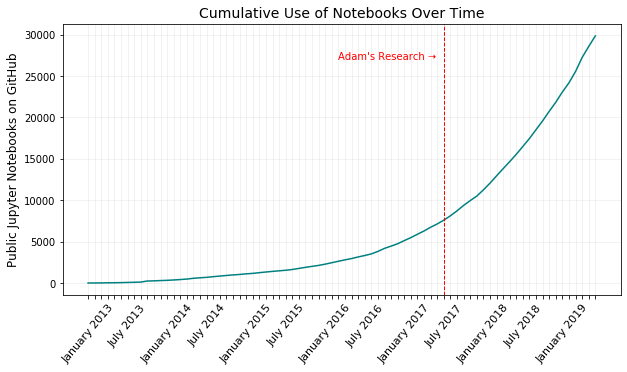

In [59]:
fig = plt.figure(figsize=(10, 5))
plt.plot(
    monthly_counts['order'][:-1],
    monthly_counts['cumulative'][:-1], 
    color = 'teal'
)
plt.xticks(
    ticks = monthly_counts['order'][:-1],
    labels = monthly_counts['labels'][:-1], 
    fontsize=11, rotation=50
)
plt.ylabel('Public Jupyter Notebooks on GitHub', fontsize = 12)
plt.title('Cumulative Use of Notebooks Over Time', fontsize = 14)

plt.axvline(54, color = 'red', linewidth = 1, linestyle = '--')
plt.text(38, 27000, 'Adam\'s Research ➝', color = 'red')

plt.grid(alpha = 0.2)
plt.show()

Plot number of new notebooks per month. Again, leave out the last month because it is underestimated.

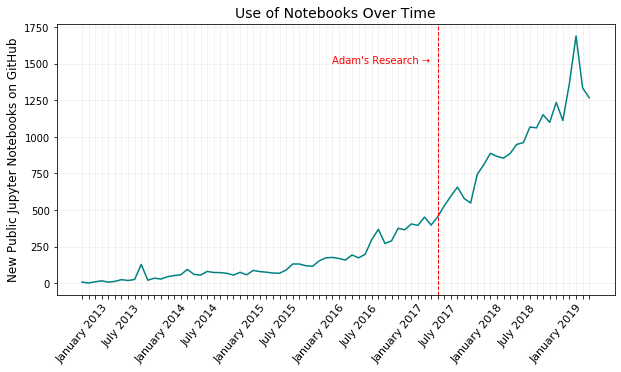

In [61]:
fig = plt.figure(figsize=(10, 5))
plt.plot(monthly_counts['order'][:-1],monthly_counts['count'][:-1], color = 'teal')
plt.xticks(
    ticks = monthly_counts['order'][:-1], 
    labels = monthly_counts['labels'][:-1], 
    fontsize=11, rotation=50
)
plt.ylabel('New Public Jupyter Notebooks on GitHub', fontsize = 12)
plt.title('Use of Notebooks Over Time', fontsize = 14)

plt.axvline(54, color = 'red', linewidth = 1, linestyle = '--')
plt.text(38, 1500, 'Adam\'s Research ➝', color = 'red')

plt.grid(alpha = 0.2)
plt.show()

In [46]:
avg_diff = monthly_counts['count'][:-1].diff().mean()
avg_diff_before = monthly_counts[monthly_counts['year']<2018]['count'].diff().mean()
avg_diff_after = monthly_counts[monthly_counts['year']>=2018]['count'][:-1].diff().mean()

print("On average, the number of notebooks on github has increased by {0} notebooks per month.".format(
    round(avg_diff, 2)
))
print("""
Before 2018, the number of notebooks on github increased, on average, by {0} notebooks a month. 
Since 2018, that number has gone up more than {1} fold, with an average increase of {2} notebooks per month.""".format(
    round(avg_diff_before, 2),
    int(avg_diff_after//avg_diff_before),
    round(avg_diff_after, 2)
))

On average, the number of notebooks on github has increased by 16.38 notebooks per month.

Before 2018, the number of notebooks on github increased, on average, by 9.17 notebooks a month. 
Since 2018, that number has gone up more than 3 fold, with an average increase of 30.82 notebooks per month.


## Is this exponential?

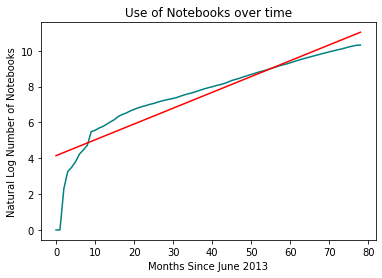

In [55]:
x = monthly_counts['order']
y = [math.log(y) if y != 0 else 0 for y in monthly_counts['cumulative']]

best_fit = np.polyfit(x, y, 1)

plt.plot(x, y, color = 'teal')
plt.plot(np.unique(x), np.poly1d(best_fit)(np.unique(x)), color = 'red')

plt.xlabel('Months Since June 2013')
plt.ylabel('Natural Log Number of Notebooks')
plt.title('Use of Notebooks over time')
plt.show()

An exponential model does not fit the data very well.

<center> <a href = Questions.ipynb>Table of Contents &lt;</a> | <a href = 2_Languages.ipynb>&gt; Language Use</a> <center>